# Classification of Red and Blue Datapoints using a Neural Network

## Import Libraries

In [331]:
import sklearn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from torch import nn

## Create 1000 Samples

In [332]:
n_samples = 1000 #make_circles creates a series of datapoint (of quantity 'n') in a circular pattern

X,y = make_circles(n_samples, noise = 0.03, random_state = 42)
len(X), len(y)

(1000, 1000)

## Create a Pandas Dataframe

In [333]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "Label": y})

In [334]:
circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


## Visualize the Sample Data

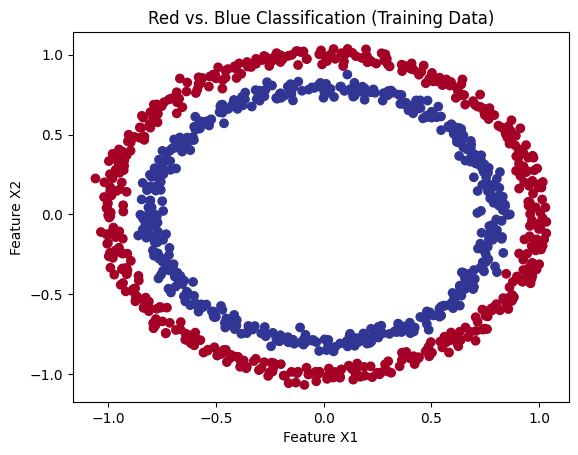

In [335]:
plt.scatter(x = X[:,0],
            y = X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)
plt.xlabel("Feature X1")
plt.ylabel("Feature X2")
plt.title("Red vs. Blue Classification (Training Data)")
plt.show()

#Each of the points in this toy-dataset carries an X1 and an X2 value as well as a binary y-label of either 0 or 1
#The point of this excercise will be to learn the relationships between the feature values and the label designation
#This will allow classification of future datapoints as belonging to either the 'red' or 'blue' category seen below

## Check Dimensionality of Inputs and Outputs

In [336]:
X.shape, y.shape

((1000, 2), (1000,))

## Convert Data from Numpy Arrays to PyTorch Tensors

In [337]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(f"X dtype: {X.dtype}, y dtype: {y.dtype}")

X dtype: torch.float32, y dtype: torch.float32


## Split the Data into Training and Test Sets

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


## Build a Neural Network Classification Model

we will:

  1. Setup device agnostic code so our model will one on an accelerator (GPU) if there is one available
  
  2. Construct a model as subclass of nn.Module

  3. Define a loss function and optimizer

  4. Create a training and test loop

### Set up device agnostic condtions

In [339]:
# Set up device agnostic condtions

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"



### Create a model that subclasses nn.Module

In [340]:
# Create a model that subclasses nn.module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    #create 2 nn.linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5) #the input is 'scaled up' from 2 to 5 numbers to try and better learn their patterns

    self.layer_2 = nn.Linear(in_features = 5, out_features = 1) #input features of the second layer must match ouput features of 1st layer
                                                                #output features of second layer is 1 because we're treating it as the output layer
                                                                #where there is exactly one label output for each data feature input

  #Define a forward method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) #layer_2 is being treated as the output layer and so the forward function returns layer_2 with an input of layer_1, which has an input of X



### Instantiate our model and send it to the target device

In [341]:
#Instantiate our model class and send it to the target device

model_0 = CircleModelV0().to(device)

#Inspect parameters

model_0.state_dict()



OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

### Make untrained predictions with the model

In [342]:
#Make untrained predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of Predictions: {len(untrained_preds)}, Size: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of Predictions: 200, Size: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Setup a Loss Function and Optimizer

In [343]:
# We will use Binary Cross Entropy as the loss function for classification
# BCE and BCE with logits are the two most common loss functions for classification problems
#Two of the most common optimizers are Stochastic Gradient Descent (SGD) and Adam

loss_fn = nn.BCEWithLogitsLoss() #Utilizes a built-in sigmoid-activation function

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1) #SGD optimizer is now set to optimize all parameters of model_0 where gradient tracking is set to True

## Create an Accuracy Evaluation Function

In [344]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item() #.eq() evaluates whether the values fed to it are equal.
                                                 #This chaining give us the sum of instances where the prediction is equal to the real value and returns it to us as a single number
  accuracy = (correct/len(y_pred)) * 100
  return accuracy # we return the percentage of accurate predictions

## Build a Training Loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backwards propagation)
5. Optimizer step (gradient descent)

In [345]:
#Our output will be in raw logits (the log of a probability)
#We can convert these logits into prediction possibilities by passing them into some kind of activation function
#Sigmoid works for binary classification, Softmax is more appropriate for multiclass classification

#Then we can convert prediction probabilites to prediction labels by either rounding them or taking the argmax()

In [346]:
# View the first 5 logits (model is still untrained)

model_0.eval() #model is set to eval mode before making predictions
with torch.inference_mode():
  y_logits = model_0(X_test).to(device)[:5].squeeze()

y_logits

tensor([-0.1269, -0.0967, -0.1908, -0.1089, -0.1667])

In [347]:
# We can put these logits through a sigmoid activation function to convert them to probabilities
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([0.4683, 0.4758, 0.4524, 0.4728, 0.4584])

In [348]:
# We can then round these probabilities to place them in either a 0 or 1 format
# However, as mentioned, the BCE with Logit loss function uses its own built in logit activation function

torch.round(y_pred_prob)



tensor([0., 0., 0., 0., 0.])

#### Training Loop

In [349]:
torch.manual_seed(42)
epochs = 100

#Assign data to target device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)



for epoch in range(epochs):

  model_0.train() #places the model into a training modality

  # 1. Forward Pass
  y_logits = model_0(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits)) #turns logits into prediction probabilities, which are then turned into prediction labels

  # 2. Calculate loss/accuracy

  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss() expects raw logits as inputs
                                    # this loss function will feed raw logits into its own buitin sigmoid activation function
                                    # If we were using nn.BCELoss(), prediction probabilities would be expected as input

  accuracy = accuracy_fn(y_train, y_pred)

  # 3. Optimizer Zero Grad

  optimizer.zero_grad()

  # 4. Loss Backward (back propagation)

  loss.backward()

  #5. Optimizer Step (gradient descent)
  optimizer.step()


  model_0.eval() #We take the model out  of training mode and reset it to testing mode

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_accuracy = accuracy_fn(y_test, test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")




Epoch: 0, Test Loss: 0.6972116827964783, Test Accuracy: 50.0%
Epoch: 10, Test Loss: 0.696153998374939, Test Accuracy: 50.0%
Epoch: 20, Test Loss: 0.6958542466163635, Test Accuracy: 48.5%
Epoch: 30, Test Loss: 0.6957688331604004, Test Accuracy: 47.5%
Epoch: 40, Test Loss: 0.6957288384437561, Test Accuracy: 46.5%
Epoch: 50, Test Loss: 0.6956887245178223, Test Accuracy: 46.5%
Epoch: 60, Test Loss: 0.6956409215927124, Test Accuracy: 46.5%
Epoch: 70, Test Loss: 0.6955873370170593, Test Accuracy: 46.5%
Epoch: 80, Test Loss: 0.6955310702323914, Test Accuracy: 46.5%
Epoch: 90, Test Loss: 0.6954748630523682, Test Accuracy: 46.5%


## Visualize Predictions with Helper Function

- At this point, model accuracy is not particularly high

- We will use the plot_decision_boundary function to try and visualize why this might be

In [350]:
import requests
from pathlib import Path

# helper function downloaded from Learn PyTorch repo

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")

else:
  print("downloading helper_functions.py")

  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

  from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


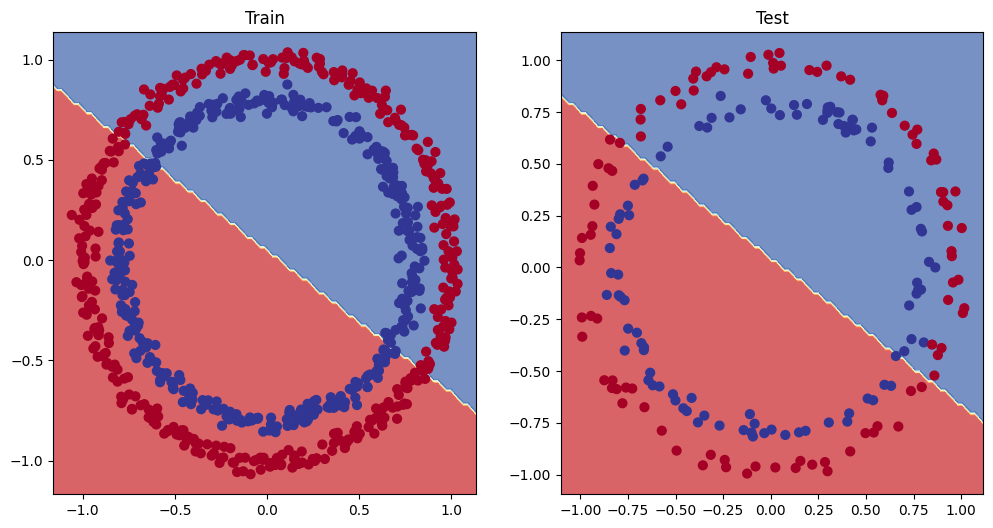

In [351]:
# Plot decision boundary for the model

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


## Visualization shows:

  1. A purely linear model is innappropriate for the non-linear nature of this data

  2. Increasing training epochs or number of linear layers alone will not improve accuracy

  3. Decision boundaries need to be drawn by either:

      a. rebuilding the model around the Radial Base Function

      b. feeding the output of linear layers through a reLU() activation function



## Build a New Model

### This model will contain more linear layers and a reLU() activation function

In [352]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    #create 3 nn.linear layers with increased neurons
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)

    self.layer_2 = nn.Linear(in_features = 10, out_features = 20)

    self.layer_3 = nn.Linear(in_features = 20, out_features = 1 )

    self.relu = nn.ReLU() #allows the network to approximate non-linear function and learn complex non-linear boundaries


  #Define a forward method that outlines the forward pass
  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_1 = CircleModelV1().to(device)

print(model_1)




CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


## Redefine Loss Function and Optimizer for New Model

In [353]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

## Train the New Model

In [354]:
torch.manual_seed(42)
epochs = 10001 #new model will be trained across 10,000 epochs

#Assign data to target device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)



for epoch in range(epochs):

  model_1.train() #places the model into a training modality

  # 1. Forward Pass
  y_logits = model_1(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits)) #turns logits into prediction probabilities, which are then turned into prediction labels

  # 2. Calculate loss/accuracy

  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss() expects raw logits as inputs
                                    # this loss function will feed raw logits into its own buitin sigmoid activation function
                                    # If we were using nn.BCELoss(), prediction probabilities would be expected as input

  accuracy = accuracy_fn(y_train, y_pred)

  # 3. Optimizer Zero Grad

  optimizer.zero_grad()

  # 4. Loss Backward (back propagation)

  loss.backward()

  #5. Optimizer Step (gradient descent)
  optimizer.step()


  model_1.eval() #We take the model out  of training mode and reset it to testing mode

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_accuracy = accuracy_fn(y_test, test_preds)

    if epoch % 1000 == 0:
      print(f"Epoch: {epoch},Loss: {loss}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")




Epoch: 0,Loss: 0.6926181316375732, Test Loss: 0.6925286650657654, Test Accuracy: 56.49999999999999%
Epoch: 1000,Loss: 0.6197202801704407, Test Loss: 0.6142364740371704, Test Accuracy: 77.0%
Epoch: 2000,Loss: 0.03337911143898964, Test Loss: 0.05125707760453224, Test Accuracy: 100.0%
Epoch: 3000,Loss: 0.010122070088982582, Test Loss: 0.02491047792136669, Test Accuracy: 99.5%
Epoch: 4000,Loss: 0.005841947626322508, Test Loss: 0.018439726904034615, Test Accuracy: 99.5%
Epoch: 5000,Loss: 0.004129936918616295, Test Loss: 0.015928154811263084, Test Accuracy: 99.5%
Epoch: 6000,Loss: 0.0032055529300123453, Test Loss: 0.014715468510985374, Test Accuracy: 99.5%
Epoch: 7000,Loss: 0.0026256185956299305, Test Loss: 0.013950565829873085, Test Accuracy: 99.5%
Epoch: 8000,Loss: 0.0022248956374824047, Test Loss: 0.013450494036078453, Test Accuracy: 99.5%
Epoch: 9000,Loss: 0.0019288572948426008, Test Loss: 0.013186639174818993, Test Accuracy: 99.5%
Epoch: 10000,Loss: 0.0017049032030627131, Test Loss: 0.0

## Visualize Decision Boundary for New Model

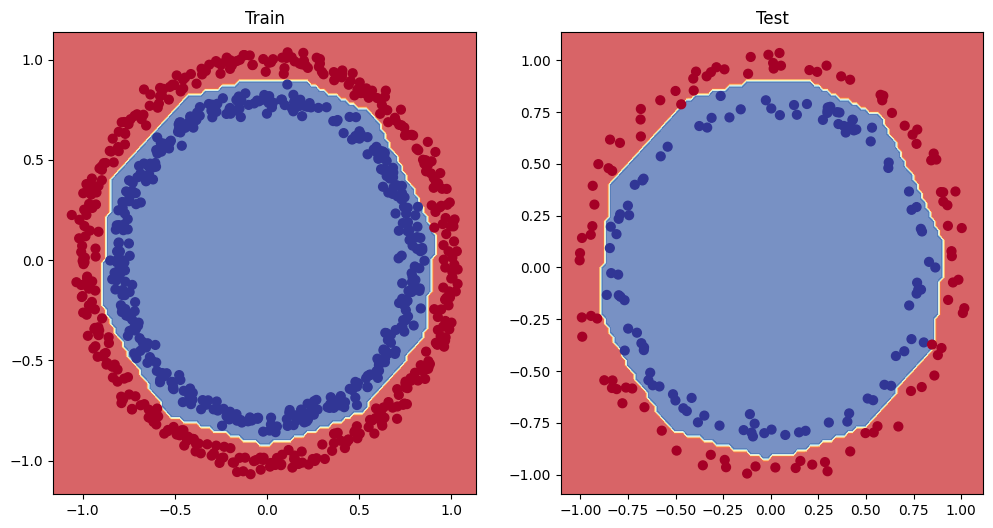

In [355]:
# Plot decision boundary for the model
# We can see the decision boundary almost perfectly accomodates the non-linear nature of the two groups

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)


## Create a Single-Prediction Function

In [375]:
def single_prediction(x:torch.tensor):
  model_1.eval()
  x = x.unsqueeze(0).to(device)

  with torch.inference_mode():
    single_logit = model_1(x).squeeze()
    single_pred = torch.round(torch.sigmoid(single_logit))
    #print(single_pred.squeeze())
  if single_pred.item() == 1:
    return "This point is predicted to be blue"

  else:
    return "This point is predicted to be red"


# Make predictions

prediction_1 = single_prediction(torch.tensor([0.0,-0.4]))

prediction_2 = single_prediction(torch.tensor([0.5,-0.9]))

print(f"Data point located at coordinates (0.0,-0.4): {prediction_1}")
print(f"Data point located at coordinates (0.5, -0.9): {prediction_2}")




Data point located at coordinates (0.0,-0.4): This point is predicted to be blue
Data point located at coordinates (0.5, -0.9): This point is predicted to be red
